# Caching nearest neighbors / 缓存最近邻居

This examples demonstrates how to precompute the k nearest neighbors before
using them in KNeighborsClassifier. KNeighborsClassifier can compute the
nearest neighbors internally, but precomputing them can have several benefits,
such as finer parameter control, caching for multiple use, or custom
implementations.

Here we use the caching property of pipelines to cache the nearest neighbors
graph between multiple fits of KNeighborsClassifier. The first call is slow
since it computes the neighbors graph, while subsequent call are faster as they
do not need to recompute the graph. Here the durations are small since the
dataset is small, but the gain can be more substantial when the dataset grows
larger, or when the grid of parameter to search is large.

此示例演示了如何在 KNeighborsClassifier 中使用 k 个最近邻居之前对其进行预计算。KNeighborsClassifier 可以在内部计算最近邻居，但预计算它们可以带来多种好处，例如更精细的参数控制、缓存以供多次使用或自定义实现。

在这里，我们使用管道的缓存属性来缓存 KNeighborsClassifier 的多个拟合之间的最近邻居图。第一次调用很慢，因为它计算邻居图，而后续调用更快，因为它们不需要重新计算图。这里的持续时间很短，因为数据集很小，但当数据集变大或要搜索的参数网格很大时，增益会更大。

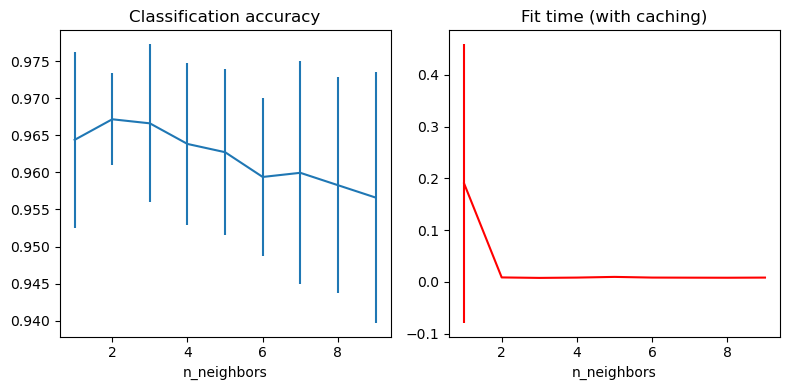

In [1]:
# Author: Tom Dupre la Tour
#
# License: BSD 3 clause
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.pipeline import Pipeline

X, y = load_digits(return_X_y=True)
n_neighbors_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# The transformer computes the nearest neighbors graph using the maximum number
# of neighbors necessary in the grid search. The classifier model filters the
# nearest neighbors graph as required by its own n_neighbors parameter.
graph_model = KNeighborsTransformer(n_neighbors=max(n_neighbors_list), mode="distance")
classifier_model = KNeighborsClassifier(metric="precomputed")

# Note that we give `memory` a directory to cache the graph computation
# that will be used several times when tuning the hyperparameters of the
# classifier.
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    full_model = Pipeline(
        steps=[("graph", graph_model), ("classifier", classifier_model)], memory=tmpdir
    )

    param_grid = {"classifier__n_neighbors": n_neighbors_list}
    grid_model = GridSearchCV(full_model, param_grid)
    grid_model.fit(X, y)

# Plot the results of the grid search.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_test_score"],
    yerr=grid_model.cv_results_["std_test_score"],
)
axes[0].set(xlabel="n_neighbors", title="Classification accuracy")
axes[1].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_fit_time"],
    yerr=grid_model.cv_results_["std_fit_time"],
    color="r",
)
axes[1].set(xlabel="n_neighbors", title="Fit time (with caching)")
fig.tight_layout()
plt.show()